In this script we'll query the database with SQL and we'll visualize the output with ggplot2. There are two reason why I chose to do the visualization with R rather Python: firstly, I am more proficient with ggplot2 than I am with seaborn or matplotlib and secondly I'd like to showcase my knowledge of multiple programming languages.

# Loading the libraries

We'll use the odbc library to connect to our database

In [1]:
suppressWarnings(suppressPackageStartupMessages(library(odbc)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))

# Connecting to the database

Let's have a look at the available drivers

In [2]:
sort(unique(odbcListDrivers()[[1]]))

[1] "Microsoft Access Driver (*.mdb, *.accdb)"              
 [2] "Microsoft Access Text Driver (*.txt, *.csv)"           
 [3] "Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)"
 [4] "ODBC Driver 17 for SQL Server"                         
 [5] "PostgreSQL ANSI"                                       
 [6] "PostgreSQL ANSI(x64)"                                  
 [7] "PostgreSQL Unicode"                                    
 [8] "PostgreSQL Unicode(x64)"                               
 [9] "SQL Server"                                            
[10] "SQL Server Native Client 11.0"                         
[11] "SQL Server Native Client RDA 11.0"

Let's connect to our postgreSQL database by using the "PostgreSQL Unicode(x64)" driver

In [3]:
con <- DBI::dbConnect(odbc(),
                      Driver   = "PostgreSQL Unicode(x64)",
                      Server   = Sys.getenv('rds_postgres_imdb_host'),
                      Database = "postgres_imdb",
                      UID      = Sys.getenv('rds_postgres_imdb_username'),
                      PWD      = Sys.getenv('rds_postgres_imdb_psw'),
                      Port     = 5432)

The tables in our database

In [4]:
dbListTables(con)

[1] "films"  "people" "stats"

# Querying and visualizing the data

## Genre popularity across time

Let's see what the most frequent genres are. The 'genre' column often contains multiple values separated by a semicolon. Let's split and unnest it. 

In [5]:
query <- "SELECT UNNEST(STRING_TO_ARRAY(genre, ';')), 
                 COUNT(*)
          FROM films
          GROUP BY 1 
          ORDER BY 2 DESC
          LIMIT 10"

dbGetQuery(conn = con, statement = query)

unnest,count
<chr>,<int64>
Drama,2346
Comedy,1711
Thriller,1514
Action,1326
Adventure,934
Crime,868
Romance,829
Science Fiction,642
Horror,634


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



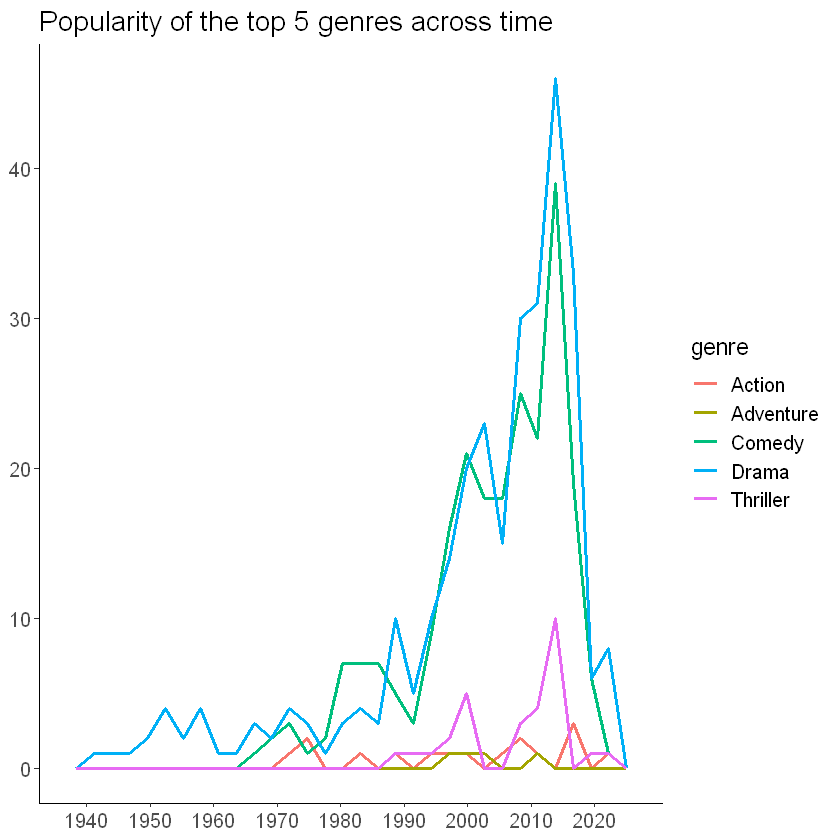

In [6]:
query  <- "SELECT EXTRACT(YEAR FROM release_date :: DATE) AS year,
                  UNNEST(STRING_TO_ARRAY(genre, ';')) genre
           FROM films
           WHERE genre IN ('Drama', 'Comedy', 'Thriller', 'Action', 'Adventure')"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = year, colour = genre)) +
geom_freqpoly(size = 1) +
scale_x_continuous(breaks = seq(1930, 2020, 10)) +
ggtitle("Popularity of the top 5 genres across time") +
theme_classic() +
theme(title = element_text(size = 14),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_text(size = 12),
      axis.text.y = element_text(size = 12),
      legend.title = element_text(size = 14),
      legend.text = element_text(size = 12))

## Decades with most films

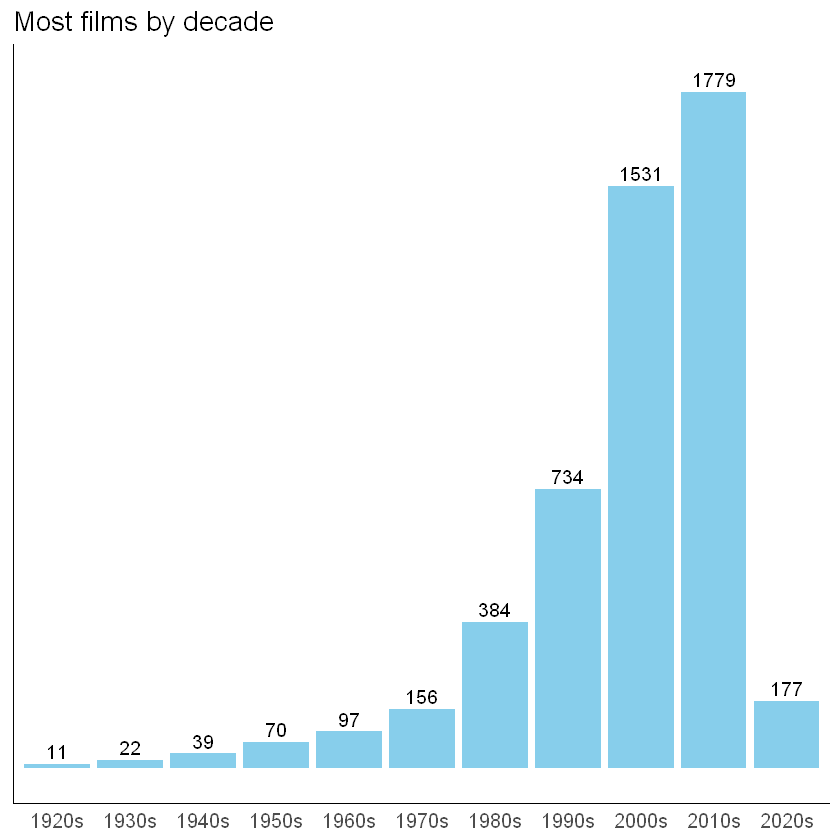

In [7]:
query <- "SELECT CASE WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 2020 THEN '2020s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 2010 AND EXTRACT(YEAR FROM release_date :: DATE) < 2020 THEN '2010s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 2000 AND EXTRACT(YEAR FROM release_date :: DATE) < 2010 THEN '2000s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1990 AND EXTRACT(YEAR FROM release_date :: DATE) < 2000 THEN '1990s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1980 AND EXTRACT(YEAR FROM release_date :: DATE) < 1990 THEN '1980s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1970 AND EXTRACT(YEAR FROM release_date :: DATE) < 1980 THEN '1970s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1960 AND EXTRACT(YEAR FROM release_date :: DATE) < 1970 THEN '1960s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1950 AND EXTRACT(YEAR FROM release_date :: DATE) < 1960 THEN '1950s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1940 AND EXTRACT(YEAR FROM release_date :: DATE) < 1950 THEN '1940s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1930 AND EXTRACT(YEAR FROM release_date :: DATE) < 1940 THEN '1930s'
                      WHEN EXTRACT(YEAR FROM release_date :: DATE) >= 1920 AND EXTRACT(YEAR FROM release_date :: DATE) < 1930 THEN '1920s'
                      ELSE '1910s or earlier' END AS Decade,
                COUNT(*)
          FROM films
          GROUP BY 1 
          ORDER BY 2 DESC
"

dbGetQuery(conn = con, statement = query)  %>% 
ggplot(aes(x = decade, y = as.numeric(count))) +
geom_col(fill = "sky blue") +
geom_text(aes(label = as.numeric(count)), nudge_y = 35, size = 4) +
theme_classic() +
ggtitle("Most films by decade") +
theme(title = element_text(size = 14),
      axis.text.x = element_text(size = 12),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank(),
      axis.text.y = element_blank())

## Directors by most films in the database

Who are the directors with most films among the top 5000 most rated films on IMDB? Again we'll need to use split and unnest.

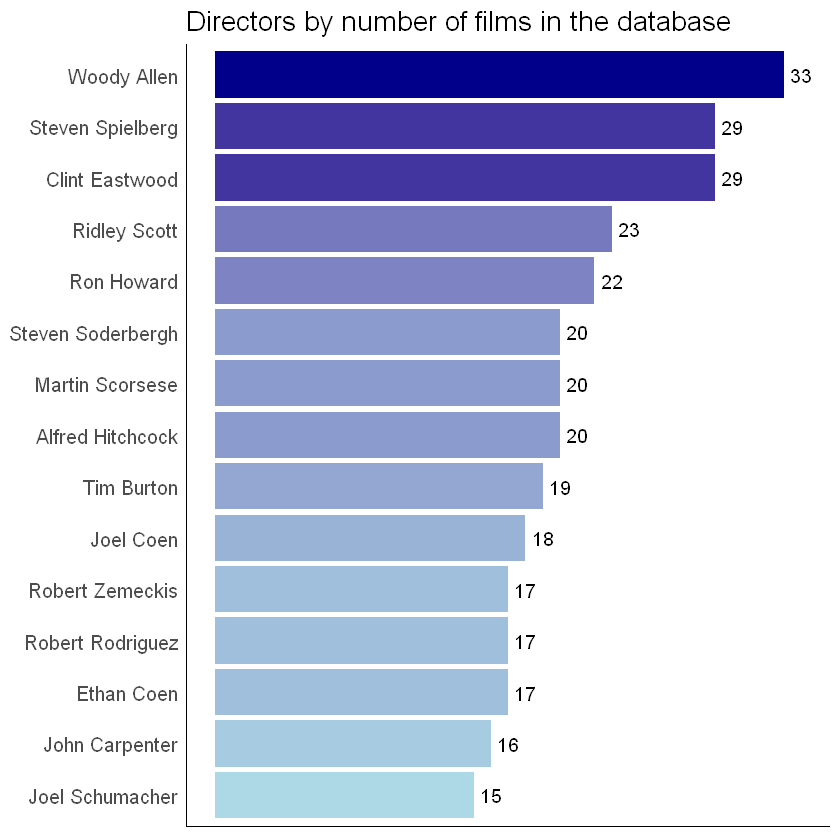

In [8]:
query <- "SELECT UNNEST(STRING_TO_ARRAY(director, ';')) director, 
          COUNT(*) n_of_films
          FROM people
          GROUP BY 1
          ORDER BY 2 DESC
          LIMIT 15"

dbGetQuery(conn = con, statement = query) %>% 
  ggplot(aes(x = fct_reorder(director, n_of_films), y = as.numeric(n_of_films), fill = as.numeric(n_of_films))) +
  geom_col() +
  geom_text(aes(label = as.factor(n_of_films)), nudge_y = 1, size = 4) +
  coord_flip() +
  theme_classic() +
  ggtitle("Directors by number of films in the database") +
  theme(title = element_text(size = 14),
        legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 12),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_blank()) +
  scale_fill_gradient(low = "light blue", high = "dark blue")

## Directors with highest average ratings

Let's do something similar but this time we'll calculate the average film rating for directors having at least 5 films in the dataset. We'll also add a third column containing the titles and year of those films.

In [9]:
query <- "SELECT UNNEST(STRING_TO_ARRAY(director, ';')) director,
                 ROUND(AVG(imdb_rating :: NUMERIC), 2) avg_rating, 
                 STRING_AGG(title || ' (' || EXTRACT(YEAR FROM release_date :: DATE) || ')', ' | ') films
          FROM people 
          JOIN stats USING (id) 
          JOIN films USING (id)
          GROUP BY 1 
          HAVING COUNT(*) > 4
          ORDER BY 2 DESC
          LIMIT 15"

output_two <- dbGetQuery(conn = con, statement = query)
output_two

director,avg_rating,films
<chr>,<dbl>,<chr>
Charles Chaplin,8.33,Modern Times (1936) | City Lights (1931) | The Circus (1928) | The Kid (1921) | The Gold Rush (1925) | The Great Dictator (1940)
Sergio Leone,8.23,"Once Upon a Time in America (1984) | Once Upon a Time in the West (1968) | For a Few Dollars More (1965) | A Fistful of Dollars (1964) | Duck, You Sucker (1971) | The Good, the Bad and the Ugly (1966)"
Akira Kurosawa,8.22,Seven Samurai (1954) | Ran (1985) | Rashomon (1950) | The Hidden Fortress (1958) | Throne of Blood (1957) | Yojimbo (1961) | Sanjuro (1962) | Kagemusha (1980) | High and Low (1963) | Ikiru (1952)
Christopher Nolan,8.16,Following (1999) | Dunkirk (2017) | Batman Begins (2005) | Interstellar (2014) | Tenet (2020) | The Dark Knight Rises (2012) | Memento (2000) | The Prestige (2006) | The Dark Knight (2008) | Insomnia (2002) | Inception (2010)
Ingmar Bergman,8.15,Fanny and Alexander (1982) | Cries and Whispers (1972) | The Seventh Seal (1957) | Persona (1966) | Wild Strawberries (1957) | Autumn Sonata (1978)
Lee Unkrich,8.14,"Toy Story 2 (1999) | Finding Nemo (2003) | Toy Story 3 (2010) | Coco (2017) | Monsters, Inc. (2001)"
Stanley Kubrick,8.09,2001: A Space Odyssey (1968) | Paths of Glory (1957) | Full Metal Jacket (1987) | Dr. Strangelove (1964) | A Clockwork Orange (1971) | Barry Lyndon (1975) | The Shining (1980) | Spartacus (1960) | The Killing (1956) | Eyes Wide Shut (1999) | Lolita (1962)
Andrei Tarkovsky,8.08,Andrei Rublev (1966) | Solaris (1972) | Ivan's Childhood (1962) | Stalker (1979) | Mirror (1975)
Rajkumar Hirani,8.08,Lage Raho Munna Bhai (2006) | 3 Idiots (2009) | Munna Bhai M.B.B.S. (2003) | PK (2014) | Sanju (2018)


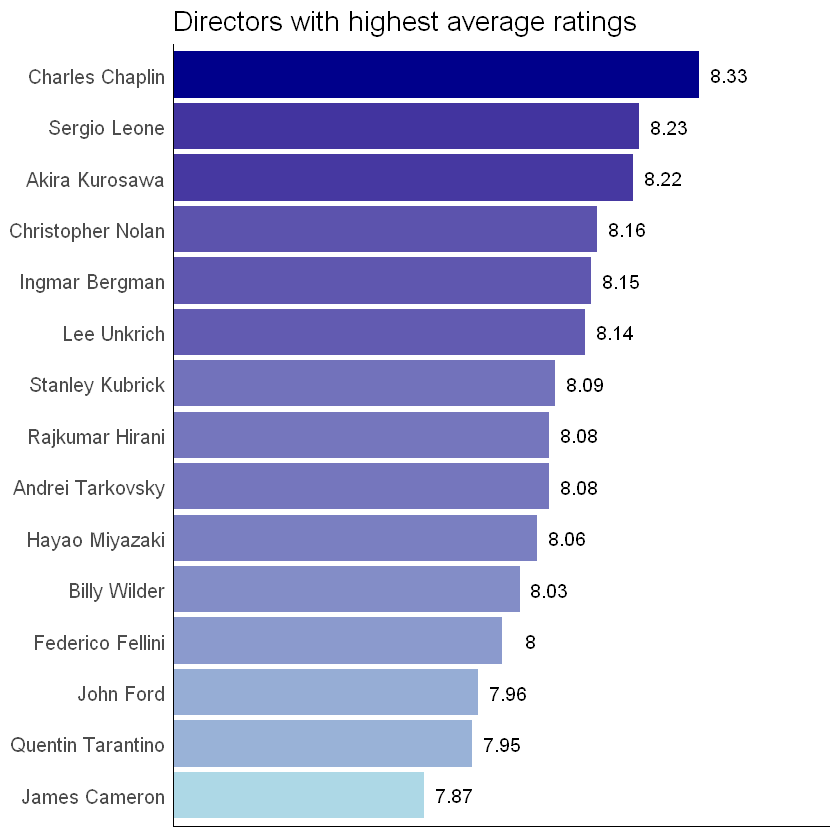

In [10]:
output_two %>% 
ggplot(aes(x = fct_reorder(director, avg_rating), 
           y = avg_rating, 
           fill = avg_rating)) +
geom_col() +
geom_text(aes(label = avg_rating), nudge_y = 0.05, size = 4) +
coord_flip(ylim = c(7.5, 8.5)) +
theme_classic() +
ggtitle("Directors with highest average ratings") +
theme(legend.position = 'none',
      title = element_text(size = 14),
      axis.text.x = element_blank(),
      axis.text.y = element_text(size = 12),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +
scale_fill_gradient(low = "light blue", high = "dark blue")

## People with most film credits

Let's now find out who the people with most film credits are. We'll include directors, producers, cinematographers, costume designers etc. To do this, we'll first unpivot all the columns from the 'people' table, then we'll split and unnest the resulting column and count the occurrences of each name.

Mark Falvo and Jimmy Star mostly work as extras in big Hollywood productions.

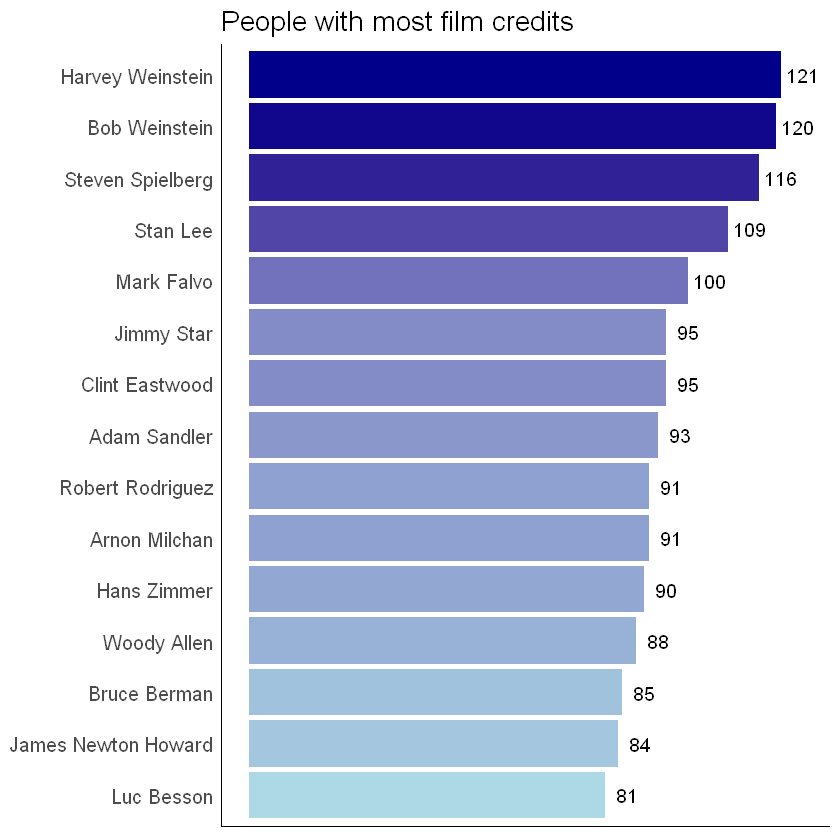

In [11]:
query  <-  "WITH CTE AS (SELECT UNNEST(ARRAY[director, writer, actors, cinematographer, editor, composer, 
                                 production_designer, art_director, costume_designer, producers]) people
FROM people)

SELECT UNNEST(STRING_TO_ARRAY(people, ';')) people, 
       COUNT(*) n_of_credits
FROM CTE
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 15"

dbGetQuery(conn = con, statement = query) %>% 
ggplot(aes(x = fct_reorder(people, n_of_credits), y = as.numeric(n_of_credits), fill = as.numeric(n_of_credits))) +
geom_col() +
geom_text(aes(label = as.numeric(n_of_credits)), nudge_y = 5, size = 4) +
coord_flip() +
theme_classic() +
ggtitle("People with most film credits") +
theme(title = element_text(size = 14),
      legend.position = "none",
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_text(size = 12),
      axis.ticks.x = element_blank(),
      axis.ticks.y = element_blank()) +
scale_fill_gradient(low = "light blue", high = "dark blue")